In [9]:
import numpy as np

In [10]:
def load_txt(path):
    f=open(path, "r")
    if(path[-3:] == 'txt'):
        contents =f.readlines()

        dataset = np.zeros((len(contents)-2,len(contents[2].split('\t'))-1))
        label = np.zeros((len(contents)-2))

        for i in range(len(contents)-2):
            x = contents[i+2].split("\t")
            for j in range(len(x)):
                if j != len(x) - 1 :
                    dataset[i][j] = float(x[j])
                else :
                    label[i] = float(x[j][:-1])
    else :
        contents =f.readlines()
        n_data = int(len(contents)/3)
        dataset = np.zeros((n_data,2))
        label = np.zeros((n_data,2))
        j = 0
        count = 0
        for i in range(len(contents)):
            if(j == 1):
                dataset[count][0] = float(contents[i].split()[0])
                dataset[count][1] = float(contents[i].split()[1])
            if(j == 2):
                label[count][0] = int(contents[i].split()[0])
                label[count][1] = int(contents[i].split()[1])
                count = count + 1
                j = -1
            j += 1
            
    return dataset,label

def norm(data_r):
    data = data_r.copy()
    datanorm = (data - data.min())/(data.max() - data.min()) 
    return datanorm, data.max(), data.min()

def convert_norm(pred,mx,mn):
    return pred*(mx - mn) + mn

In [11]:
import numpy as np
class NN :
    
    def __init__(self,shape,nueral_shape,acti_funct):
        shape[1:1] = nueral_shape 
        self.shape = shape
        self.act_func = acti_funct
        self.weights = self.init_weights(self.shape)
        self.outputs = None
        self.deltas = None
        self.del_old_weights = None
        
    def init_old_weights(self,network_shape):
        weight_arrays = []
        for i in range(0, len(network_shape) - 1):
            cur_idx = i
            next_idx = i + 1
            weight_array = np.zeros((network_shape[next_idx], network_shape[cur_idx]))
            weight_arrays.append(weight_array)
        
        return weight_arrays
    
    def init_weights(self,network_shape):
        weight_arrays = []
        for i in range(0, len(network_shape) - 1):
            cur_idx = i
            next_idx = i + 1
            weight_array = 2*np.random.rand(network_shape[next_idx], network_shape[cur_idx]) - 1
            weight_arrays.append(weight_array)

        return weight_arrays


    def predict(self,sample):
        
        current_input =  (sample.copy()).T
        outputs = []
        for network_weight in self.weights:
            current_output_temp = np.dot(network_weight, current_input)
            current_output = self.acti_funct(current_output_temp)
            outputs.append(current_output)
            current_input = current_output
        
        if(self.shape[-1] == 1) :
            return current_output.T
        else :
            tp = None 
            fp = None 
            for i in range(len(outputs[-1])):
                if( i == 0) :
                    tp = outputs[-1][i]
                else :
                    fp = outputs[-1][i]
                    tp = np.vstack((tp, fp)).T
            return np.argmax(tp, axis=1)
                    
    def train(self,sample, d_out, training_rate,momentum_rate,epoch,show=True):
        sample_T = (sample.copy()).T
        d_out_T = (d_out.copy()).T
        for i in range(epoch):
            self.FW_NN(sample_T)
            self.BW_NN(d_out_T)
            self.update_weights(sample_T,learning_rate,momentum_rate,i)
            sqe = self.sum_sqaure_error(self.predict(sample),d_out_T)
            if(show and i % 10 == 0):
                print('Epoch : #'+str(i)+',  Sum Square Error : '+str(sqe))
            if sqe < np.finfo(np.float32).eps :
                break
                
    def FW_NN(self,input):

        current_input = input
        outputs = []
        for w in self.weights:
            current_output_tmp = np.dot(w, current_input)
            current_output = self.acti_funct(current_output_tmp)
            outputs.append(current_output)
            current_input = current_output
        self.outputs = outputs
        
    def BW_NN(self,d_out):
        
        deltas = []
        O_error = d_out - self.outputs[len(self.outputs)-1]
        O_delta = O_error *self.derivertive_acti_funct(self.outputs[len(self.outputs)-1])
        deltas.append(O_delta)

        cur_delta = O_delta
        back_idx = len(self.outputs) - 2

        for w in self.weights[::-1][:-1]:
            hidd_error = np.dot(w.T, cur_delta)
            hidd_delta = hidd_error * self.derivertive_acti_funct(self.outputs[back_idx])
            deltas.append(hidd_delta)
            cur_delta = hidd_delta
            back_idx -= 1
            
        self.deltas = deltas
    
    def update_weights(self,sample,learning_rate,momentum_rate,count):
        index_current_weight = len(self.weights) - 1
        current_dels = []
        for d in self.deltas:
            sample_used = None
            if index_current_weight - 1 < 0:
                sample_used = sample
            else:
                sample_used = self.outputs[index_current_weight - 1]
                
            current_delta = learning_rate*np.dot(d, sample_used.T)
            
            if(count == 0) :
                self.weights[index_current_weight] +=  current_delta
            else :
                self.weights[index_current_weight] +=  momentum_rate*self.del_old_weights[index_current_weight]+ current_delta
            index_current_weight -= 1
            current_dels.insert(0, current_delta)
            
        self.del_old_weights = current_dels

    def acti_funct(self,v):
        if self.act_func == 'sigmoid' :
            return 1 / (1 + np.exp(-v))
        if self.act_func == 'tanh' :
            return np.tanh(v)
        if self.act_func == 'linear' :
            return v
        return v

    def derivertive_acti_funct(self,v):
        if self.act_func == 'sigmoid' :
            return v * (1 - v)
        if self.act_func == 'tanh' :
            return 1 - (v ** 2)
        if self.act_func == 'linear' :
            return 1
        return v

        
    def sum_sqaure_error(self,pred,real):
        real_m = real.copy()
        sums = 0
        if(real.ndim > 1) :
            tp = None 
            fp = None 
            for i in range(len(real_m)):
                if( i == 0) :
                    tp = real_m[i]
                else :
                    fp = real_m[i]
                    tp = np.vstack((tp, fp)).T
            real_m = np.argmax(tp, axis=1)
        for i in range(len(pred)):
            sums = sums + np.square(pred[i]-real_m[i])
        return sums/2
    
    def conf_matrix(self,pred,true,is_norm=False,confuse=True,Table=True):
        true_m = np.zeros(len(true))
        if(true.ndim > 1) :
            for i in range(len(true)):
                true_m[i] = np.argmax(true[i], axis=0)
        if(is_norm):
            sqr_error = 0 
            if(Table):
                print('Desired Output\t\t|\tPredict\t\t\t|\tError')
                print('-----------------------------------------------------------------------------')
            for i in range(len(true)):
                error = round(true[i] - round(pred[i][0],8),2)
                if(Table):
                    print(str(int(true[i]))+'\t\t\t\t|\t'+str(format(round(pred[i][0],8), '.8f'))+'\t\t|\t'+str(error))
                sqr_error = sqr_error + (error * error)
            if(Table):
                print('-----------------------------------------------------------------------------')
                print('\t\t Mean Square Error = '+str(round(sqr_error/len(true),6)))
                print('=======================================')
            return round(sqr_error/len(true),6)
        else :
            if(Table):
                print('Desired Output\t\t|\tPredict\t\t\t')
                print('------------------------------------------------')
                for i in range(len(true)):
                    print(str(int(true_m[i]))+'\t\t\t\t|\t'+str(pred[i]))
                print('------------------------------------------------')
        if(confuse):
            print('\n\t\t Confusion Matrix')
            TP = 0
            FN = 0
            FP = 0
            TN = 0
            for i in range(len(true)):
                if((pred[i] == 0) and ( true_m[i] == 0)):
                    TN = TN + 1 
                elif((pred[i] == 1) and ( true_m[i] == 1)):
                    TP = TP + 1
                elif((pred[i] == 1) and ( true_m[i] == 0)):
                    FP = FP + 1
                else :
                    FN = FN + 1

            print(' ----------------------------------------')
            for i in range(8):
                print('|\t\t\t|\t\t\t|')
                if(i == 1):
                    print('|\t    '+str(TN)+'\t\t|\t    '+str(FP)+'\t\t|\t '+str(FP+TN))
                if(i == 3):
                    print(' ----------------------------------------')
                if(i == 5):
                    print('|\t    '+str(FN)+'\t\t|\t    '+str(TP)+'\t\t|\t '+str(FN+TP))
            print(' ----------------------------------------')
            print(' \t    '+str(TN+FN)+'\t\t       '+str(FP+TP)+'\t\t\t'+str(TN+FP+FN+TP))
            print('')
            print('Accuracy : '+str((TN+TP)/(TN+FP+FN+TP)))
            return((TN+TP)/(TN+FP+FN+TP))

In [12]:
def load_data(name,cross):
    is_norm = False
    if(name  == 1):
        dataset,label = load_txt("./Flood_dataset.txt")
        dataset,mx_dataset,mn_dataset = norm(dataset)
        label,mx_label,mn_label = norm(label)
        is_norm = True
        max_min = [mx_dataset,mn_dataset,mx_label,mn_label]
    else :
        dataset,label = load_txt("./cross.pat")
    n_sample = np.arange(len(dataset))
    np.random.shuffle(n_sample)
    if(is_norm) :
        return dataset,label,n_sample,max_min
    else :
        return dataset,label,n_sample

In [13]:
def MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num) :
    if(data_num == 0):
        print('------------------- Variable -------------------\n')
        dataset,label,n_sample = load_data(data_num,cross_valda_train_test)
        data_name = 'cross.pat'
    else :
        print('-------------------------------- Variable --------------------------------\n')
        dataset,label,n_sample,max_min = load_data(data_num,cross_valda_train_test)
        data_name = 'Flood data set'
    n_test_per_round = int(len(dataset)*cross_valda_train_test[1]/100)
    print('Datafile : ' +str(data_name),end='\n')
    print('Nueral name : '+str(len(dataset[0]))+'-',end='')
    for i in range(len(Nueral)):
        print(str(Nueral[i])+'-',end='')
    print(label.ndim,end='\n')
    print('Learning rate : '+str(learning_rate),end='\n')
    print('Momentum rate : '+str(momentum_rate),end='\n')
    print('Activaion Function : ' +str(activation),end='\n')
    print('Cross validation : ['+str(cross_valda_train_test[0])+' : '+str(cross_valda_train_test[1])+']',end='\n')
    print('#Epoch : '+str(epoch),end='\n')
    error_avg = []
    acc_avg = []
    for i in range(10):
        test_data = n_sample[i*n_test_per_round:i*n_test_per_round+n_test_per_round]
        train_data = list(set(n_sample) - set(test_data))
        nn = NN([len(dataset[0]),label.ndim],Nueral,activation)
        nn.train(dataset[train_data],label[train_data],learning_rate,momentum_rate,epoch,False)
        pred = nn.predict(dataset[test_data])
        if(data_num == 1):
#             print('\n-------------------------------- Round : '+str(i)+' --------------------------------')
            pred = convert_norm(pred,max_min[2],max_min[3])
            test_label = convert_norm(label[test_data],max_min[2],max_min[3])
            error_avg.append(nn.conf_matrix(pred,test_label,is_norm=True,confuse=False,Table=True))
        else :
#             print('\n----------------- Round : '+str(i)+' -----------------')
            acc_avg.append(nn.conf_matrix(pred,label[test_data],is_norm=False,confuse=True,Table=True))
    if(data_num == 1):
        print('\n********  Mean Square Error Average : ' + str(round(np.sum(error_avg)/len(error_avg),4))+'  *********')
        print(np.min(error_avg))
        return round(np.sum(error_avg)/len(error_avg),4),np.min(error_avg)
    else :
        print('\n********  Accuracy Average : ' + str(round(np.sum(acc_avg)/len(acc_avg),4))+'  *********')
        return round(np.sum(acc_avg)/len(acc_avg),4),np.max(acc_avg)

In [22]:
error_arr = np.zeros(100)
minn_arr = np.zeros(100)
for i in range(1,100):
    Nueral = [14,9] 
    cross_valda_train_test = [90,10] # train 90 , test 10
    data_num = 0 # 0 = cross.pat , 1 = flood data set
    learning_rate = i*0.01
    momentum_rate = 0.07
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn

------------------- Variable -------------------

Datafile : cross.pat
Nueral name : 2-14-9-2
Learning rate : 0.01
Momentum rate : 0.07
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 1000

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    2		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    7		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    11		       9			20

Accuracy : 0.65

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    4		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    7		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.7

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    9		|	 12
|			|			|
|			|			|
 -----------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    0		|	 7
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    10		|	 13
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.85

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    13		|	    0		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    5		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    15		       5			20

Accuracy : 0.9

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    12		|	    1		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    4		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    15		       5			20

Accuracy : 0.8

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    1		|	 7
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    8		|	 13
|			|			|
|			|			|
 ----------------------------------------
 	    11		       9			20

Accuracy : 0.7

********  Accuracy Average : 0.84  *********
------------------- Variable -------------------

Datafile : cross.pat
Nueral name : 2-14-9-2
Learning rate : 0.06
Momentum rate : 0.07
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 1000

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    2		|	 5
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    13		|	 15
|			|			|
|			|			|
 ----------------------------------------
 	    5		       15			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    13		|	    0		|	 13
|			|			|


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    5		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    15		       5			20

Accuracy : 0.7

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    1		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    7		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    12		       8			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    1		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    4		|	    5		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    14		       6			20

Accuracy : 0.75

		 Confusion Matrix
 ---------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    13		|	    0		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    6		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    14		       6			20

Accuracy : 0.95

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    0		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    4		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    16		       4			20

Accuracy : 0.6

********  Accuracy Average : 0.855  *********
------------------- Variable -------------------

Datafile : cross.pat
Nueral name : 2-14-9-2
Learning rate : 0.11
Momentum rate : 0.07
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 1000

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    1		|	 10
|			|			


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    2		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    9		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.85

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    0		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    8		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    12		       8			20

Accuracy : 0.9

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    3		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    4		|	    4		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    13		       7			20

Accuracy : 0.65

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    0		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    11		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.95

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    13		|	    0		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    5		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    15		       5			20

Accuracy : 0.9

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    1		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    3		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    16		       4			20

Accuracy : 0.7

********  Accuracy Average : 0.85  *********
--------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    2		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    7		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    11		       9			20

Accuracy : 0.85

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    1		|	 7
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    10		|	 13
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    14		|	    0		|	 14
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    5		|	 6
|			|			|
|			|			|
 ----------------------------------------
 	    15		       5			20

Accuracy : 0.95

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    5		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    7		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    8		       12			20

Accuracy : 0.65

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    2		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    8		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.75

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    3		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    10		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    7		       13			20

Accuracy : 0.85

		 Confusion Matrix
 ------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    1		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    7		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    12		       8			20

Accuracy : 0.85

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    2		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    8		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    3		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    11		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    6		       14			20

Accuracy : 0.85

		 Confusion Matrix
 ------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    2		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    8		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.75

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    2		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    9		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    8		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    12		       8			20

Accuracy : 0.85

		 Confusion Matrix
 ---------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    4		|	 15
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    5		|	 5
|			|			|
|			|			|
 ----------------------------------------
 	    11		       9			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    1		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    12		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    7		       13			20

Accuracy : 0.95

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    2		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    8		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.9

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    3		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    8		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    1		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    7		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    12		       8			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    3		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    7		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.6

		 Confusion Matrix
 ----------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    3		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    9		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    8		       12			20

Accuracy : 0.75

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    3		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    9		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    8		       12			20

Accuracy : 0.75

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    1		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    10		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.85

		 Confusion Matrix
 --------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    4		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    8		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    8		       12			20

Accuracy : 0.7

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    2		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    9		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.85

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    1		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    7		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    12		       8			20

Accuracy : 0.85

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    5		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    5		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.65

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    0		|	 7
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    10		|	 13
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.85

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    5		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    8		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    7		       13			20

Accuracy : 0.65

		 Confusion Matrix
 -----------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    3		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    9		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    8		       12			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    1		|	 6
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    12		|	 14
|			|			|
|			|			|
 ----------------------------------------
 	    7		       13			20

Accuracy : 0.85

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    3		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    9		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    8		       12			20

Accuracy : 0.75

		 Confusion Matrix
 --------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    3		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    6		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    11		       9			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    6		|	 14
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    6		|	 6
|			|			|
|			|			|
 ----------------------------------------
 	    8		       12			20

Accuracy : 0.7

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    0		|	 5
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    15		|	    0		|	 15
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.25

		 Confusion Matrix
 ---------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    2		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    4		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    14		       6			20

Accuracy : 0.6

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    12		|	    0		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    0		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.6

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    2		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    9		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.85

		 Confusion Matrix
 --------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    1		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    8		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    11		       9			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    2		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    8		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.75

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    2		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    6		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    12		       8			20

Accuracy : 0.8

		 Confusion Matrix
 ---------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    4		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    10		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    6		       14			20

Accuracy : 0.75

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.45

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    4		|	    3		|	 7
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    12		|	 13
|			|			|
|			|			|
 ----------------------------------------
 	    5		       15			20

Accuracy : 0.8

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    5		|	 14
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    6		|	 6
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.75

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    2		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    8		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    10		       10			20

Accuracy : 0.9

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    9		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    10		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    1		       19			20

Accuracy : 0.55

		 Confusion Matrix
 ------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.55

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    0		|	 6
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    14		|	    0		|	 14
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.3

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.55

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.45

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.55

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    4		|	    9		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    6		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    5		       15			20

Accuracy : 0.5

		 Confusion Matrix
 --------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    4		|	    9		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    7		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    4		       16			20

Accuracy : 0.55

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    0		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    0		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.5

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    2		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    6		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    12		       8			20

Accuracy : 0.85

		 Confusion Matrix
 ------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    0		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    10		|	    0		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.5

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    5		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    8		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    7		       13			20

Accuracy : 0.65

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    4		|	    4		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    9		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    7		       13			20

Accuracy : 0.65

		 Confusion Matrix
 ------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    8		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    8		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    4		       16			20

Accuracy : 0.55

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    5		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    8		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    7		       13			20

Accuracy : 0.65

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    8		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    12		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.6

		 Confusion Matrix
 --------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.55

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    0		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    12		|	    0		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.4

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    0		|	 7
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    13		|	    0		|	 13
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.35

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    10		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    8		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    2		       18			20

Accuracy : 0.5

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    13		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    7		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.35

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.45

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    7		|	 7
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    13		|	 13
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.65

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    15		|	    0		|	 15
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    0		|	 5
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.75

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    0		|	 7
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    13		|	    0		|	 13
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.35

		 Confusion Matrix
 ------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    5		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    6		|	    2		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    13		       7			20

Accuracy : 0.45

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    8		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    12		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.6

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.55

		 Confusion Matrix
 --------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    9		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    11		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.55

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.45

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    3		|	    10		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    5		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    5		       15			20

Accuracy : 0.4

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    12		|	    0		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    0		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.6

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.45

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.45

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    0		|	 7
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    13		|	    0		|	 13
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.35

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    9		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    11		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.55

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    12		|	    0		|	 12
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    8		|	    0		|	 8
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.6

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    10		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    10		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.5

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    2		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    9		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    9		       11			20

Accuracy : 0.8

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.45

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.55

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    11		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    9		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.45

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    2		|	    8		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    9		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    3		       17			20

Accuracy : 0.55

		 Confusion Matrix
 ------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    4		|	    6		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    10		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    4		       16			20

Accuracy : 0.7

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    6		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    1		|	    8		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    6		       14			20

Accuracy : 0.65

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    13		|	    0		|	 13
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    7		|	    0		|	 7
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.65

		 Confusion Matrix
 -------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.55

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    5		|	    5		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    10		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    5		       15			20

Accuracy : 0.75

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.55

		 Confusion Matrix
 -----------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    14		|	 14
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    6		|	 6
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.3

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    10		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    10		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.5

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    11		|	    0		|	 11
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    9		|	    0		|	 9
|			|			|
|			|			|
 ----------------------------------------
 	    20		       0			20

Accuracy : 0.55

		 Confusion Matrix
 ------------------------------


		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    9		|	 9
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    11		|	 11
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.55

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    10		|	 10
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    10		|	 10
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.5

		 Confusion Matrix
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    8		|	 8
|			|			|
|			|			|
 ----------------------------------------
|			|			|
|			|			|
|	    0		|	    12		|	 12
|			|			|
|			|			|
 ----------------------------------------
 	    0		       20			20

Accuracy : 0.6

		 Confusion Matrix
 ------------------------------

-------------------------------- Variable --------------------------------

Datafile : Flood data set
Nueral name : 8-1-1
Learning rate : 0.12
Momentum rate : 0.07
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 1000
Desired Output		|	Predict			|	Error
-----------------------------------------------------------------------------
475				|	320.79638773		|	154.2
490				|	321.16259238		|	168.84
424				|	319.10813556		|	104.89
470				|	320.44023826		|	149.56
213				|	242.15449732		|	-29.15
251				|	288.78627941		|	-37.79
433				|	316.67462131		|	116.33
210				|	241.62859952		|	-31.63
327				|	303.51576845		|	23.48
215				|	238.79172611		|	-23.79
427				|	319.33498934		|	107.67
381				|	317.44992824		|	63.55
210				|	242.32150455		|	-32.32
234				|	265.37069109		|	-31.37
221				|	236.67295019		|	-15.67
274				|	297.09813002		|	-23.1
440				|	320.02482436		|	119.98
288				|	267.41265539		|	20.59
224				|	169.79439892		|	54.21
390				|	308.40014876		|	81.6
340				|	300.01600

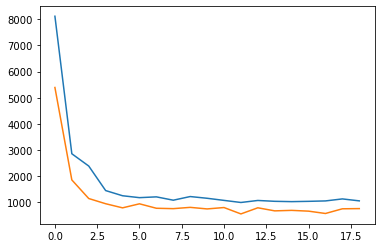

In [16]:
import matplotlib.pyplot as plt
error_arr = np.zeros(19)
minn_arr = np.zeros(19)
for i in range(1,20):
    Nueral = [i] 
    cross_valda_train_test = [90,10] # train 90 , test 10
    data_num = 1 # 0 = cross.pat , 1 = flood data set
    learning_rate = 0.12
    momentum_rate = 0.07
    activation = 'sigmoid'
    epoch = 1000
    error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
    error_arr[i-1] = error
    minn_arr[i-1] = minn
plt.plot(error_arr)
plt.plot(minn_arr)

In [ ]:
error_arr_2 = np.zeros((15,15))
minn_arr_2 = np.zeros((15,15))
for i in range(1,15):
    for j in range(1,15):
        Nueral = [i,j] 
        cross_valda_train_test = [90,10] # train 90 , test 10
        data_num = 1 # 0 = cross.pat , 1 = flood data set
        learning_rate = 0.12
        momentum_rate = 0.07
        activation = 'sigmoid'
        epoch = 1000
        error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
        error_arr_2[i-1][j-1] = error
        minn_arr_2[i-1][j-1] = minn

In [ ]:
error_arr_2

In [ ]:
error_arr_3 = np.zeros((15,15,15))
minn_arr_3 = np.zeros((15,15,15))
for i in range(1,15):
    for j in range(1,15):
        for k in range(1,15):
            Nueral = [i,j,k] 
            cross_valda_train_test = [90,10] # train 90 , test 10
            data_num = 0 # 0 = cross.pat , 1 = flood data set
            learning_rate = 0.12
            momentum_rate = 0.07
            activation = 'sigmoid'
            epoch = 1000
            error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)
            error_arr_3[i-1][j-1][k-1] = error 
            minn_arr_3[i-1][j-1][k-1] = minn

In [24]:
for i in range(1,100):
    print(error_arr[i])
    

0.68
0.82
0.84
0.84
0.845
0.865
0.82
0.83
0.855
0.845
0.88
0.875
0.89
0.85
0.88
0.845
0.895
0.82
0.84
0.88
0.76
0.785
0.77
0.84
0.86
0.85
0.82
0.815
0.79
0.795
0.805
0.83
0.735
0.765
0.75
0.76
0.755
0.835
0.76
0.7
0.68
0.7
0.745
0.73
0.78
0.665
0.68
0.685
0.685
0.73
0.62
0.69
0.535
0.54
0.64
0.625
0.56
0.6
0.605
0.625
0.525
0.665
0.675
0.54
0.55
0.555
0.48
0.49
0.555
0.535
0.585
0.545
0.55
0.615
0.525
0.575
0.48
0.485
0.495
0.5
0.585
0.58
0.475
0.52
0.48
0.52
0.515
0.48
0.52
0.51
0.55
0.515
0.45
0.46
0.515
0.505
0.495
0.5
0.0


In [26]:

Nueral = [14,9] 
cross_valda_train_test = [90,10] # train 90 , test 10
data_num = 1 # 0 = cross.pat , 1 = flood data set
learning_rate = 0.12
momentum_rate = 0.07
activation = 'sigmoid'
epoch = 1000
error,minn = MLP(Nueral,learning_rate,momentum_rate,activation,epoch,cross_valda_train_test,data_num)

-------------------------------- Variable --------------------------------

Datafile : Flood data set
Nueral name : 8-14-9-1
Learning rate : 0.12
Momentum rate : 0.07
Activaion Function : sigmoid
Cross validation : [90 : 10]
#Epoch : 1000
Desired Output		|	Predict			|	Error
-----------------------------------------------------------------------------
213				|	226.48806774		|	-13.49
240				|	237.96621354		|	2.03
208				|	224.18326097		|	-16.18
331				|	330.29774317		|	0.7
404				|	385.26539284		|	18.73
462				|	454.85847521		|	7.14
164				|	161.98602733		|	2.01
428				|	392.44928478		|	35.55
410				|	391.08761285		|	18.91
350				|	267.45258364		|	82.55
234				|	230.55872787		|	3.44
209				|	224.86329120		|	-15.86
490				|	480.29888289		|	9.7
441				|	430.11540187		|	10.88
250				|	262.42418440		|	-12.42
478				|	481.58998367		|	-3.59
210				|	227.08168555		|	-17.08
464				|	468.13004474		|	-4.13
160				|	161.36067736		|	-1.36
410				|	359.71109155		|	50.29
288				|	244.29305918		|	43.71

Desired Output		|	Predict			|	Error
-----------------------------------------------------------------------------
465				|	472.52930239		|	-7.53
490				|	483.05269443		|	6.95
323				|	340.10838650		|	-17.11
468				|	477.40857055		|	-9.41
444				|	455.72751208		|	-11.73
385				|	406.04593186		|	-21.05
330				|	336.21124430		|	-6.21
433				|	425.06607205		|	7.93
413				|	406.82647249		|	6.17
457				|	456.08592227		|	0.91
468				|	471.65099551		|	-3.65
153				|	166.12520626		|	-13.13
246				|	202.59664350		|	43.4
390				|	374.09307963		|	15.91
238				|	238.11543445		|	-0.12
440				|	452.16693660		|	-12.17
427				|	434.69242367		|	-7.69
300				|	313.33499830		|	-13.33
322				|	348.13872644		|	-26.14
215				|	231.64600989		|	-16.65
470				|	473.11481054		|	-3.11
451				|	466.61218808		|	-15.61
340				|	278.34858589		|	61.65
490				|	483.38194268		|	6.62
291				|	313.10991428		|	-22.11
308				|	315.87803140		|	-7.88
436				|	448.40130967		|	-12.4
192				|	174.51107838		|	17.49
247				|	261.7